In [23]:
# Import general python packages used by scientists
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gc
import os
import pandas as pd

# Import packages  Image Access
import lsst.daf.butler as dafButler
import lsst.geom as geom
from lsst.geom import PointD
from lsst.geom import Point2D
import lsst.afw.display as afwDisplay
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius
from lsst.afw import cameraGeom

# Import packages for  Catalog Access
import pandas
pandas.set_option('display.max_rows', 1000)
from lsst.rsp import get_tap_service, retrieve_query

#Import custom packages
from ellipticity_mapping import calculate_ellipticity_on_xy
from collection_dictionary_shared import collection_dictionary

from datetime import datetime, timedelta
from astroplan import Observer
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from pytz import all_timezones #To visualize all the possible timezones
from pytz import timezone
import datetime
import time

In [24]:
timestamp = time.time()  # Example timestamp
datetime_object = datetime.datetime.fromtimestamp(timestamp)
formatted_datetime = datetime_object.strftime("%Y%m%dT%H%M%S")

In [25]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector
    
def pixel_to_focal(x, y, det):
    """
    Parameters
    ----------
    x, y : array
        Pixel coordinates.
    det : lsst.afw.cameraGeom.Detector
        Detector of interest.
    Returns
    -------
    fpx, fpy : array
        Focal plane position in millimeters in DVCS
        See https://lse-349.lsst.io/
    """
    tx = det.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    fpx, fpy = tx.getMapping().applyForward(np.vstack((x, y)))
    return fpx.ravel(), fpy.ravel()

In [26]:
seqnums = [52]
seqnums = [36, 37, 38, 39, 40, 41, 42, 43, 44]
detectors = [168, 178, 188, 123, 132, 142, 152, 161, 75, 84, 94, 104, 113, 27, 36, 46, 56, 65, 0, 10, 20]
format_figures = 'png'

In [27]:
collection_dict = collection_dictionary()

In [28]:
# #Define the butler data configuration and collection (una tantum ) 
# config = '/home/v/vittorio/rubin-user/projects/imsim/imSim/repo'
# folderout = '/home/v/vittorio/rubin-user/projects/imsim/imSim/repo/ellipticitymap/'
# subfolderout_fig = 'figures/'
# subfolderout_tab = 'tables/'

# do_make_figures_calexp = False
# do_make_ellipticity_in_the_center = True
# do_ellipticity_on_focalplane = True

# detector_output = []
# seqnum_output = []
# mean_e_output = []
# median_e_output = []
# std_e_output = []
# min_e_output = []
# max_e_output = []
# e0_output = []

# for seqnum in seqnums:
    
#     e_all = []
#     ex_all = []
#     ey_all = []
#     ex_all_rot = []
#     ey_all_rot = []
#     Nccd = []
#     xx = []
#     yy = []
#     xx_mm = []
#     yy_mm = []    
    
#     for detector in detectors:
        
#         visit_seqnum = 5023071800000 + seqnum
        
#         print(seqnum, detector)

#         collection = collection_dict[seqnum]

#         # Create the butler
#         butler = dafButler.Butler(config,collections=collection)

#         #Adesso dobbiammo dire al butler che tipo di dati vogliamo.
#         #La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)
#         #Qui piu' informazioni sul butler 
#         #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

#         datasetType='calexp'
#         dataId = {'visit': visit_seqnum, 'detector': detector, 'band':'r'}
#         calexp = butler.get(datasetType, **dataId)
#         sources = butler.get('src', dataId)
#         psf = calexp.getPsf()
#         bkgd = butler.get('calexpBackground', **dataId)
#         ccd = calexp.detector.getId()
#         det = calexp.getDetector()
#         wcs = calexp.getWcs()
#         calexp_info = calexp.getInfo()
        
#         if do_ellipticity_on_focalplane:
#             rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()
#             coo = wcs.pixelToSky(2036.0, 2000.0)
#             point = geom.Point2D(2036, 2000)
#             fpx, fpy = pixel_to_focal(point[0], point[1], det)
#             Ixx = psf.computeShape(point).getIxx()
#             Iyy = psf.computeShape(point).getIyy()
#             Ixy = psf.computeShape(point).getIxy()
#             theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
#             #theta.append(np.arctan2(2. * Ixy, Ixx - Iyy) / 2.)
#             e1 = (Ixx - Iyy) / (Ixx + Iyy)
#             e2 = (2. * Ixy) / (Ixx + Iyy)
#             e = np.sqrt(e1**2 + e2**2)
#             ex = e * np.cos(theta)
#             ey = e * np.sin(theta)
#             ex_rot = ex*np.cos(np.radians(rot)) - ey*np.sin(np.radians(rot))
#             ey_rot = ex*np.sin(np.radians(rot)) + ey*np.cos(np.radians(rot))
#             e_all.append(e)
#             ex_all.append(ex)
#             ey_all.append(ey)
#             ex_all_rot.append(ex_rot)
#             ey_all_rot.append(ey_rot)
#             Nccd.append(ccd)
#             xx.append(coo[0].asDegrees())
#             yy.append(coo[1].asDegrees())
#             xx_mm.append(fpx)
#             yy_mm.append(fpy)
                    
#         if do_make_figures_calexp:
#     #################################        
#     # Display figures (inizio)
#     #################################        

#             # create a matplotlib.pyplot figure
#             fig = plt.figure()
#             #Display the image with lsst.afw.display

#             #The next task is to let AFWDisplay know that we want it to use matplotlib as our default display backend.
#             #To do this, we use the setDefaultBackend() function. Remember that we made an alias to lsst.afw.display called afwDisplay in the import
#             afwDisplay.setDefaultBackend('matplotlib')
#             # get an alias to the lsst.afw.display.Display() method
#             display = afwDisplay.Display(frame=fig)
#             # set the image stretch algorithm and range
#             display.scale('asinh', 'zscale')
#             # load the image into the display
#             display.mtv(calexp.image)
#             # show the corresponding pyplot figure
#             plt.title("Image Seqnum {:04d} Detector {:03d}".format(seqnum,detector))
#             plt.show()
#             # clean up memory
#             remove_figure(fig)

#             #Esiste un tutorial per l'utilizzo di  afw_display che il numero 3 del tutorial, da studiare perche' questo e' lo standard, 
#             #in particolare fornisce funzioi su come fare i cut, le composizioni di immagini  etc...)
#             #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/03a_Image_Display_and_Manipulation.ipynb

#             #invece il noteook dopo va su strumenti un po' piu' potenti di data display come firefly che ti apre figure iterattive che credo sia il caso di imparare

#             # #Figura con WCS
#             # fig = plt.figure()
#             # plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
#             # calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
#             #                  calexp.getBBox().beginY, calexp.getBBox().endY)
#             # im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
#             #                 extent=calexp_extent, origin='lower')
#             # plt.grid(color='white', ls='solid')
#             # plt.xlabel('Right Ascension')
#             # plt.ylabel('Declination')
#             # plt.show()
#             # remove_figure(fig)

#             #EXPLORE PSF
#             #The PSF object can be used to get a realization of a PSF at a specific point
#             fig = plt.figure()
#             psfimage = psf.computeImage(PointD(2000.,2000.))
#             display = afwDisplay.Display()
#             display.scale('asinh', min=0.0, max=1.e-3, unit='absolute')
#             display.mtv(psfimage)
#             plt.title("PSF at 2000 2000 Seqnum {:04d} Detector {:03d}".format(seqnum,detector))
#             plt.show()
#             remove_figure(fig)

#             #Visualize
#             afwDisplay.setDefaultBackend('matplotlib')

#             fig = plt.figure()
#             afw_display = afwDisplay.Display()
#             afw_display.scale('linear', 'zscale')
#             afw_display.mtv(bkgd.getImage())
#             plt.title("Local Polynomial Background Seqnum {:04d} Detector {:03d}".format(seqnum,detector))
#             plt.show()
#             remove_figure(fig)

#     #################################        
#     #Display figures (FINE)
#     #################################        

#         # Define the pixel coordinates of a point of interest
#         # (in this case, basically the central  point within the image)
#         x_target, y_target = 2000, 2000
#         point = geom.Point2D(x_target, y_target)
                    
#         # PSF width
#         sigma = psf.computeShape(point).getDeterminantRadius()
#         pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
#         # The factor of 2.355 converts from std to fwhm
#         # print('psf determinant radius={:.2f} pixel'.format(sigma))
#         # print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
        
#         #calcoliamo il TraceRadius
#         TraceRadius=psf.computeShape(point).getTraceRadius()
#         pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
#         # The factor of 2.355 converts from std to fwhm
#         # print('psf trace radius={:.2f} pixel'.format(TraceRadius))
#         # print('psf fwhm = {:.2f} arcsec'.format(TraceRadius*pixelScale*2.355))

#         if do_make_ellipticity_in_the_center:
#             #################################        
#             # Ellipticity in the center of the detector (inizio)
#             #################################        

#             #Se invece vogliamo determinare la shape a partire dai momenti adattivi.
#             Ixx=psf.computeShape(point).getIxx()
#             Iyy=psf.computeShape(point).getIyy()
#             Ixy=psf.computeShape(point).getIxy() 

#             #Questo ci serve per capire come e' stato calcolato il trace radius e il determminant radius
#             assert np.isclose(TraceRadius, np.sqrt((Ixx + Iyy) / 2.))
#             assert np.isclose(sigma, (Ixx * Iyy - Ixy**2)**(1. / 4.))

#             q = Quadrupole(Ixx, Iyy, Ixy)
#             s = SeparableDistortionTraceRadius(q)
#             theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
#             e1 = (Ixx - Iyy) / (Ixx + Iyy)
#             e2 = (2. * Ixy) / (Ixx + Iyy)
#             e = np.sqrt(e1**2 + e2**2)
#             ex = e * np.cos(theta)
#             ey = e * np.sin(theta)
#             theta_alternate = np.arctan2(e2, e1) / 2.
#             assert np.allclose(theta, theta_alternate)
#             e = np.sqrt(e1**2 + e2**2)
#             ex = e * np.cos(theta)
#             ey = e * np.sin(theta)

#             e0 = e
#             e0_output.append(e0)

#             assert np.isclose(s.getE1(), (Ixx - Iyy) / (Ixx + Iyy)) # e1
#             assert np.isclose(s.getE2(), (2. * Ixy) / (Ixx + Iyy)) # e2
#             assert np.isclose(s.getEllipticity().getTheta(), np.arctan2(2. * Ixy, Ixx - Iyy) / 2.) # theta
#             # print('e1 =', s.getE1())
#             # print('e2 =', s.getE2())
#             # print('theta =', s.getEllipticity().getTheta())

#             #################################        
#             # Ellipticity in the center of the detector (fine)
#             #################################        

#     #################################        
#     # Ellipticity on grid (inizio)
#     #################################        
            
#         regular_grid_or_star_positions = 1
#         n_grid = 200
#         # Calcolo e salva anche la griglia
#         fileout = 'ellipticitymap_seqnum{:04d}_det{:03d}.csv'.format(seqnum, detector)
#         e, ex, ey, e1, e2, xx, yy, fwhm, size = \
#             calculate_ellipticity_on_xy(calexp, sources, psf, regular_grid_or_star_positions, n_grid,
#                                        fileout=folderout+subfolderout_tab+fileout)

#         # Statistica sulle ellitticità
#         mean_e = np.mean(e)
#         median_e = np.median(e)
#         std_e = np.std(e)
#         min_e = min(e)
#         max_e = max(e)

#     #################################        
#     # Ellipticity on grid (fine)
#     #################################
    
#     #################################
#     #    OUTPUT
#     #################################
#         detector_output.append(detector)
#         seqnum_output.append(seqnum)
#         mean_e_output.append(mean_e)
#         median_e_output.append(median_e)
#         std_e_output.append(std_e)
#         min_e_output.append(min_e)
#         max_e_output.append(max_e)

#     if do_ellipticity_on_focalplane:
#         fig = plt.figure(figsize=(10,8))
#         plt.quiver(xx_mm, yy_mm, ex_all_rot, ey_all_rot, e_all,  
#            scale=0.6, headlength=0., headwidth=1., pivot='mid', width=0.005)
#         colorbar = plt.colorbar(label='ellipticity')
#         plt.clim(0., 0.04)
#         plt.xlabel('x [mm]')
#         plt.ylabel('y [mm]')
#         plt.title('Ellipticity Sticks')
#         fig.savefig(folderout+"figures/Ellipticity_Sticks_focalplane_seqnum{:04d}.pdf".format(seqnum,detector))
#         plt.close()        

# if do_make_ellipticity_in_the_center:
#     df = pd.DataFrame(data={'detector': detector_output, 'seqnum': seqnum_output, 'e0': e0_output, 
#                         'mean_e': mean_e_output, 'median_e': median_e_output, 
#                         'std_e': std_e_output, 'min_e': min_e_output, 'max_e': max_e_output})
# else:
#     df = pd.DataFrame(data={'detector': detector_output, 'seqnum': seqnum_output, 
#                         'mean_e': mean_e_output, 'median_e': median_e_output, 
#                         'std_e': std_e_output, 'min_e': min_e_output, 'max_e': max_e_output})
    
# df.to_csv(folderout+subfolderout_tab+'mean_ellipticities_231124.csv', index=False)

In [29]:
folder = '/sdf/data/rubin/shared/image_quality/imsim/'
#Define the butler data configuration and collection (una tantum )
config = folder+'repo'
folderout = folder+'ellipticitymap/'
subfolderout_fig = 'figures/'
subfolderout_tab = 'tables/'

In [33]:
# Saves to a file the information (seqnum, detector and collection) 
# associated to each run of this notebook and each output file
filedict = open(folderout+'mean_ellipticity_dictionary', 'a')  # append mode

for seq in seqnums:
    for det in detectors:
        collection = collection_dict[seqnum]
        filedict.write('{:s} {:d} {:d} {:s}\n'.format('mean_ellipticities_'+formatted_datetime+'.csv', 
                                                 seq, det, collection))

filedict.close()

In [6]:
do_make_figures_calexp = False
do_make_ellipticity_in_the_center = True
do_ellipticity_on_focalplane = True

detector_output = []
seqnum_output = []
mean_e_output = []
median_e_output = []
std_e_output = []
min_e_output = []
max_e_output = []
e0_output = []

for seqnum in seqnums:
    
    e_all = []
    ex_all = []
    ey_all = []
    ex_all_rot = []
    ey_all_rot = []
    Nccd = []
    xx = [] #coordinate x su detector
    yy = [] #coordinate x su detector
    xx_mm = [] #coordinate x su focal plane
    yy_mm = [] #coordinate y su focal plane
    
    for detector in detectors:
        
        visit_seqnum = 5023071800000 + seqnum
        
        print(seqnum, detector)

        collection = collection_dict[seqnum]

        # Create the butler
        butler = dafButler.Butler(config,collections=collection)

        #Adesso dobbiammo dire al butler che tipo di dati vogliamo.
        #La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)
        #Qui piu' informazioni sul butler 
        #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

        datasetType='calexp'
        dataId = {'visit': visit_seqnum, 'detector': detector, 'band':'r'}
        calexp = butler.get(datasetType, **dataId)
        sources = butler.get('src', dataId)
        psf = calexp.getPsf()
        bkgd = butler.get('calexpBackground', **dataId)
        ccd = calexp.detector.getId()
        det = calexp.getDetector()
        wcs = calexp.getWcs()
        calexp_info = calexp.getInfo()
        
        if do_ellipticity_on_focalplane:

        # In questa sezione, si calcola e nel pixel centrale e si crea la griglia xx_mm e yy_mm sul focal plane
            rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()
            coo = wcs.pixelToSky(2036.0, 2000.0)
            point = geom.Point2D(2036, 2000)
            fpx, fpy = pixel_to_focal(point[0], point[1], det)
            Ixx = psf.computeShape(point).getIxx()
            Iyy = psf.computeShape(point).getIyy()
            Ixy = psf.computeShape(point).getIxy()
            theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
            #theta.append(np.arctan2(2. * Ixy, Ixx - Iyy) / 2.)
            e1 = (Ixx - Iyy) / (Ixx + Iyy)
            e2 = (2. * Ixy) / (Ixx + Iyy)
            e = np.sqrt(e1**2 + e2**2)
            ex = e * np.cos(theta)
            ey = e * np.sin(theta)
            ex_rot = ex*np.cos(np.radians(rot)) - ey*np.sin(np.radians(rot))
            ey_rot = ex*np.sin(np.radians(rot)) + ey*np.cos(np.radians(rot))
            e_all.append(e)
            ex_all.append(ex)
            ey_all.append(ey)
            ex_all_rot.append(ex_rot)
            ey_all_rot.append(ey_rot)
            Nccd.append(ccd)
            xx.append(coo[0].asDegrees())
            yy.append(coo[1].asDegrees())
            xx_mm.append(fpx)
            yy_mm.append(fpy)

        if do_make_figures_calexp:
    #################################        
    # Display figures (inizio)
    #################################        

            # create a matplotlib.pyplot figure
            fig = plt.figure()
            #Display the image with lsst.afw.display

            #The next task is to let AFWDisplay know that we want it to use matplotlib as our default display backend.
            #To do this, we use the setDefaultBackend() function. Remember that we made an alias to lsst.afw.display called afwDisplay in the import
            afwDisplay.setDefaultBackend('matplotlib')
            # get an alias to the lsst.afw.display.Display() method
            display = afwDisplay.Display(frame=fig)
            # set the image stretch algorithm and range
            display.scale('asinh', 'zscale')
            # load the image into the display
            display.mtv(calexp.image)
            # show the corresponding pyplot figure
            plt.title("Image Seqnum {:04d} Detector {:03d}".format(seqnum,detector))
            plt.show()
            # clean up memory
            remove_figure(fig)

            #Esiste un tutorial per l'utilizzo di  afw_display che il numero 3 del tutorial, da studiare perche' questo e' lo standard, 
            #in particolare fornisce funzioi su come fare i cut, le composizioni di immagini  etc...)
            #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/03a_Image_Display_and_Manipulation.ipynb

            #invece il noteook dopo va su strumenti un po' piu' potenti di data display come firefly che ti apre figure iterattive che credo sia il caso di imparare

            # #Figura con WCS
            # fig = plt.figure()
            # plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
            # calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
            #                  calexp.getBBox().beginY, calexp.getBBox().endY)
            # im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
            #                 extent=calexp_extent, origin='lower')
            # plt.grid(color='white', ls='solid')
            # plt.xlabel('Right Ascension')
            # plt.ylabel('Declination')
            # plt.show()
            # remove_figure(fig)

            #EXPLORE PSF
            #The PSF object can be used to get a realization of a PSF at a specific point
            fig = plt.figure()
            psfimage = psf.computeImage(PointD(2000.,2000.))
            display = afwDisplay.Display()
            display.scale('asinh', min=0.0, max=1.e-3, unit='absolute')
            display.mtv(psfimage)
            plt.title("PSF at 2000 2000 Seqnum {:04d} Detector {:03d}".format(seqnum,detector))
            plt.show()
            remove_figure(fig)

            #Visualize
            afwDisplay.setDefaultBackend('matplotlib')

            fig = plt.figure()
            afw_display = afwDisplay.Display()
            afw_display.scale('linear', 'zscale')
            afw_display.mtv(bkgd.getImage())
            plt.title("Local Polynomial Background Seqnum {:04d} Detector {:03d}".format(seqnum,detector))
            plt.show()
            remove_figure(fig)

    #################################        
    #Display figures (FINE)
    #################################        

        # Define the pixel coordinates of a point of interest
        # (in this case, basically the central  point within the image)
        x_target, y_target = 2000, 2000
        point = geom.Point2D(x_target, y_target)
                    
        # PSF width
        sigma = psf.computeShape(point).getDeterminantRadius()
        pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
        
        #calcoliamo il TraceRadius
        TraceRadius=psf.computeShape(point).getTraceRadius()
        pixelScale = calexp.getWcs().getPixelScale().asArcseconds()

        if do_make_ellipticity_in_the_center:
            #################################        
            # Ellipticity in the center of the detector (inizio)
            #################################        

            #Se invece vogliamo determinare la shape a partire dai momenti adattivi.
            Ixx=psf.computeShape(point).getIxx()
            Iyy=psf.computeShape(point).getIyy()
            Ixy=psf.computeShape(point).getIxy() 

            #Questo ci serve per capire come e' stato calcolato il trace radius e il determminant radius
            assert np.isclose(TraceRadius, np.sqrt((Ixx + Iyy) / 2.))
            assert np.isclose(sigma, (Ixx * Iyy - Ixy**2)**(1. / 4.))

            q = Quadrupole(Ixx, Iyy, Ixy)
            s = SeparableDistortionTraceRadius(q)
            theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
            e1 = (Ixx - Iyy) / (Ixx + Iyy)
            e2 = (2. * Ixy) / (Ixx + Iyy)
            e = np.sqrt(e1**2 + e2**2)
            ex = e * np.cos(theta)
            ey = e * np.sin(theta)
            theta_alternate = np.arctan2(e2, e1) / 2.
            assert np.allclose(theta, theta_alternate)
            e = np.sqrt(e1**2 + e2**2)
            ex = e * np.cos(theta)
            ey = e * np.sin(theta)

            e0 = e
            e0_output.append(e0)

            assert np.isclose(s.getE1(), (Ixx - Iyy) / (Ixx + Iyy)) # e1
            assert np.isclose(s.getE2(), (2. * Ixy) / (Ixx + Iyy)) # e2
            assert np.isclose(s.getEllipticity().getTheta(), np.arctan2(2. * Ixy, Ixx - Iyy) / 2.) # theta
            # print('e1 =', s.getE1())
            # print('e2 =', s.getE2())
            # print('theta =', s.getEllipticity().getTheta())

            #################################        
            # Ellipticity in the center of the detector (fine)
            #################################        

    #################################        
    # Ellipticity on grid (inizio)
    #################################        
            
        regular_grid_or_star_positions = 1
        n_grid = 200
        # Calcolo e salva anche la griglia
        fileout = 'ellipticitymap_seqnum{:04d}_det{:03d}.csv'.format(seqnum, detector)
        e, ex, ey, e1, e2, xx, yy, fwhm, size = \
            calculate_ellipticity_on_xy(calexp, sources, psf, regular_grid_or_star_positions, n_grid,
                                       fileout=folderout+subfolderout_tab+fileout)

        # Statistica sulle ellitticità
        mean_e = np.mean(e)
        median_e = np.median(e)
        std_e = np.std(e)
        min_e = min(e)
        max_e = max(e)

############################
# Figura per singolo detector
############################        

### Definisco la griglia
        if regular_grid_or_star_positions == 0:
            # Per la visualizzazione della PSF su griglia regolare
            n_grid = 200
            x_array = np.arange(0, calexp.getDimensions()[0], n_grid)
            y_array = np.arange(0, calexp.getDimensions()[1], n_grid)    
            xx_det, yy_det = np.meshgrid(x_array, y_array)
            xx_for_zip = xx_det.flatten()
            yy_for_zip = yy_det.flatten()
            xxshape = xx_det.shape
        
        elif regular_grid_or_star_positions == 1:
            # Per la visualizzazione della PSF sulle coordinate delle stelle
            xx_det = [l.getCentroid()[0] for l in sources]
            yy_det = [l.getCentroid()[1] for l in sources]
            xx_for_zip = xx_det
            yy_for_zip = yy_det
            xxshape = len(xx_det)

### calcolo ellitticità sulla griglia            
            size = []
            i_xx = []
            i_yy = []
            i_xy = []
            
            for x, y in zip(xx_for_zip, yy_for_zip):
                point = Point2D(x, y)
                shape = psf.computeShape(point)
                size.append(shape.getTraceRadius())
                i_xx.append(shape.getIxx())
                i_yy.append(shape.getIyy())
                i_xy.append(shape.getIxy())
            size = np.reshape(size, xxshape)
            i_xx = np.reshape(i_xx, xxshape)
            i_yy = np.reshape(i_yy, xxshape)
            i_xy = np.reshape(i_xy, xxshape)
            
            theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
            e1 = (i_xx - i_yy) / (i_xx + i_yy)
            e2 = (2. * i_xy) / (i_xx + i_yy)
            theta_alternate = np.arctan2(e2, e1) / 2.
            assert np.allclose(theta, theta_alternate)
            e = np.sqrt(e1**2 + e2**2)
            ex = e * np.cos(theta)
            ey = e * np.sin(theta)

### plotto la figura con gli ellipticity sticks sulla griglia nel detector            
            fig = plt.figure(figsize=(8, 6))
            
            plt.quiver(xx_det, yy_det, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.005)
            colorbar = plt.colorbar(label='e')
            plt.clim(0., 0.05)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Ellipticity Sticks')
            fig.savefig(folderout+"figures/Ellipticity_Sticks_seqnum{:04d}_det{:03d}.{:s}".format(seqnum,detector,format_figures))
            plt.close()

    #################################        
    # Ellipticity on grid (fine)
    #################################

    #################################
    #    OUTPUT TABLE
    #################################
        detector_output.append(detector)
        seqnum_output.append(seqnum)
        mean_e_output.append(mean_e)
        median_e_output.append(median_e)
        std_e_output.append(std_e)
        min_e_output.append(min_e)
        max_e_output.append(max_e)

    if do_ellipticity_on_focalplane:
        fig = plt.figure(figsize=(10,8))
        plt.quiver(xx_mm, yy_mm, ex_all_rot, ey_all_rot, e_all,  
           scale=0.6, headlength=0., headwidth=1., pivot='mid', width=0.005)
        colorbar = plt.colorbar(label='ellipticity')
        plt.clim(0., 0.04)
        plt.xlabel('x [mm]')
        plt.ylabel('y [mm]')
        plt.title('Ellipticity Sticks')
        fig.savefig(folderout+"figures/Ellipticity_Sticks_focalplane_seqnum{:04d}.{:s}".format(seqnum,format_figures))
        plt.close()

if do_make_ellipticity_in_the_center:
    df = pd.DataFrame(data={'detector': detector_output, 'seqnum': seqnum_output, 'e0': e0_output, 
                        'mean_e': mean_e_output, 'median_e': median_e_output, 
                        'std_e': std_e_output, 'min_e': min_e_output, 'max_e': max_e_output})
else:
    df = pd.DataFrame(data={'detector': detector_output, 'seqnum': seqnum_output, 
                        'mean_e': mean_e_output, 'median_e': median_e_output, 
                        'std_e': std_e_output, 'min_e': min_e_output, 'max_e': max_e_output})
    
df.to_csv(folderout+subfolderout_tab+'mean_ellipticities_'+formatted_datetime+'.csv', index=False)

36 168
36 178
36 188
36 123
36 132
36 142
36 152
36 161
36 75
36 84
36 94
36 104
36 113
36 27
36 36
36 46
36 56
36 65
36 0
36 10
36 20
37 168
37 178
37 188
37 123
37 132
37 142
37 152
37 161
37 75
37 84
37 94
37 104
37 113
37 27
37 36
37 46
37 56
37 65
37 0
37 10
37 20
38 168
38 178
38 188
38 123
38 132
38 142
38 152
38 161
38 75
38 84
38 94
38 104
38 113
38 27
38 36
38 46
38 56
38 65
38 0
38 10
38 20
39 168
39 178
39 188
39 123
39 132
39 142
39 152
39 161
39 75
39 84
39 94
39 104
39 113
39 27
39 36
39 46
39 56
39 65
39 0
39 10
39 20
40 168
40 178
40 188
40 123
40 132
40 142
40 152
40 161
40 75
40 84
40 94
40 104
40 113
40 27
40 36
40 46
40 56
40 65
40 0
40 10
40 20
41 168
41 178
41 188
41 123
41 132
41 142
41 152
41 161
41 75
41 84
41 94
41 104
41 113
41 27
41 36
41 46
41 56
41 65
41 0
41 10
41 20
42 168
42 178
42 188
42 123
42 132
42 142
42 152
42 161
42 75
42 84
42 94
42 104
42 113
42 27
42 36
42 46
42 56
42 65
42 0
42 10
42 20
43 168
43 178
43 188
43 123
43 132
43 142
43 152
43 161

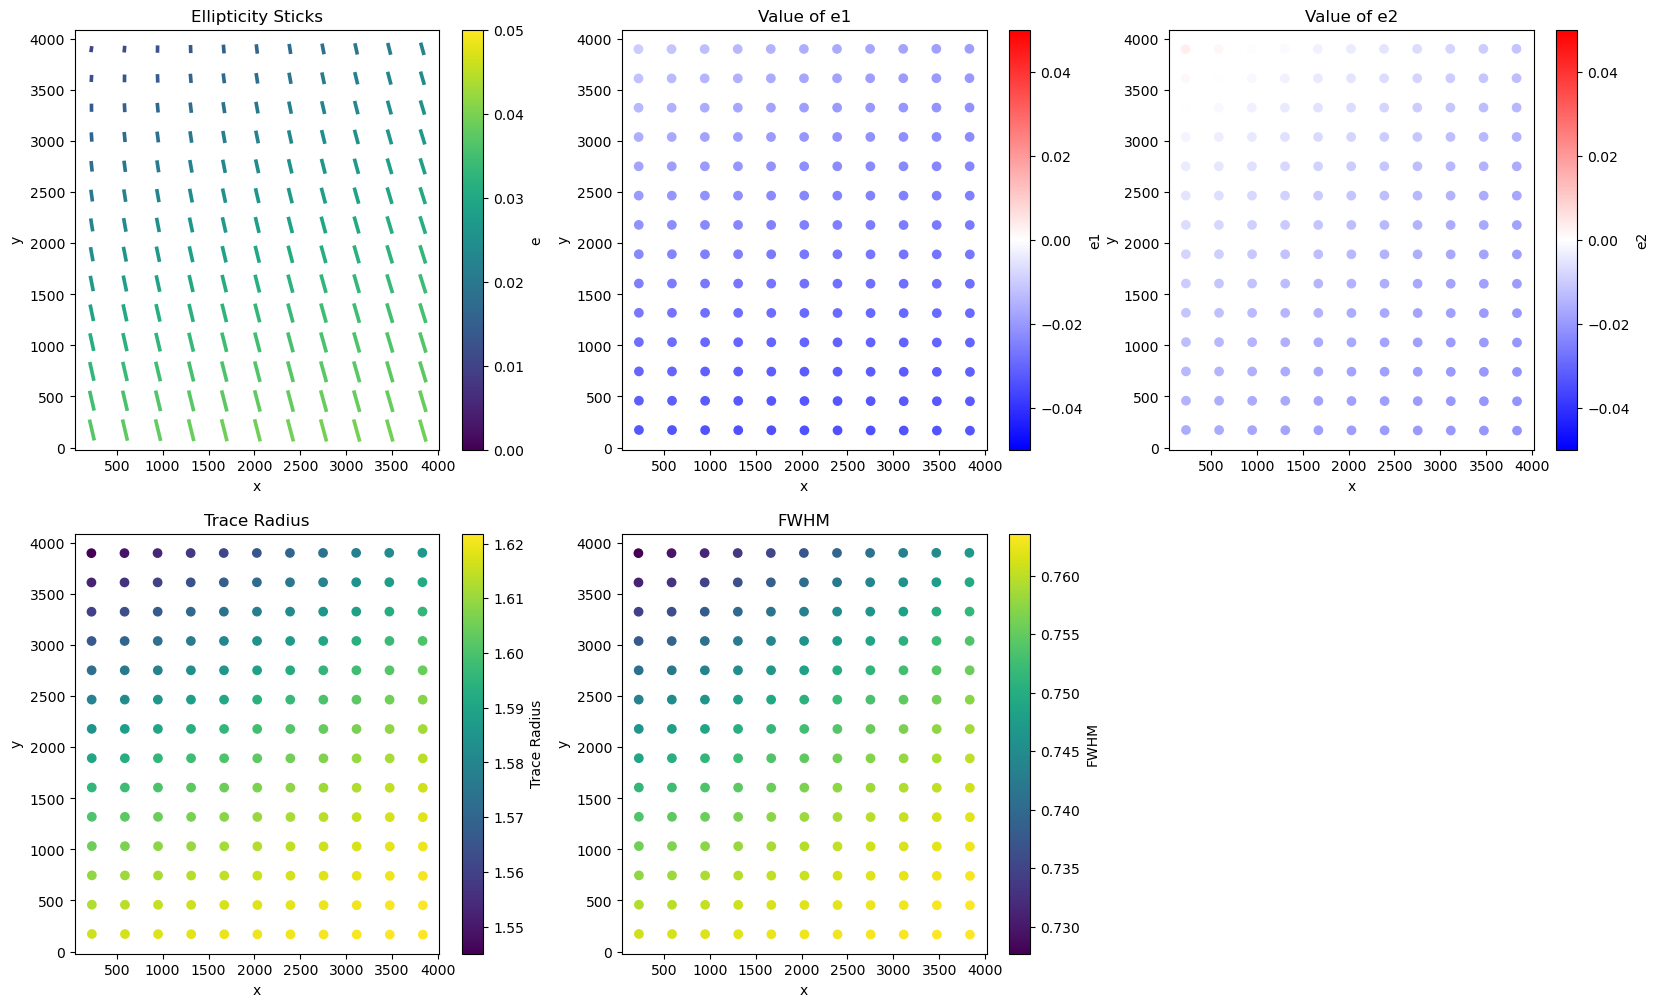

In [7]:
fig = plt.figure(figsize=(20, 12))
plt.subplots_adjust(wspace=0.2)

plt.subplot(2, 3, 1)
plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')

plt.subplot(2, 3, 2)
plt.scatter(xx, yy, c=e1, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Value of e1')

plt.subplot(2, 3, 3)
plt.scatter(xx, yy, c=e2, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Value of e2')

plt.subplot(2, 3, 4)
plt.scatter(xx, yy, c=size)
colorbar = plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trace Radius');

plt.subplot(2, 3, 5)
plt.scatter(xx, yy, c=fwhm)
colorbar = plt.colorbar(label='FWHM')
plt.xlabel('x')
plt.ylabel('y')
plt.title('FWHM');

# fig.savefig(folderout+subfolderout_fig+'ellipticity_map_seqnum.pdf')

Text(0.5, 1.0, 'Ellipticity Sticks')

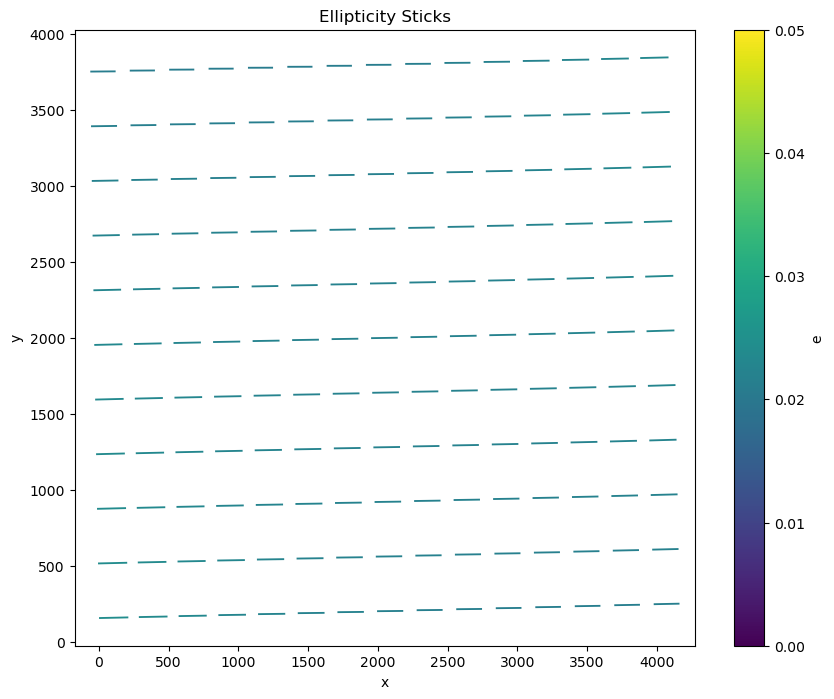

In [10]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.003)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')

Text(0.5, 1.0, 'Ellipticity Sticks')

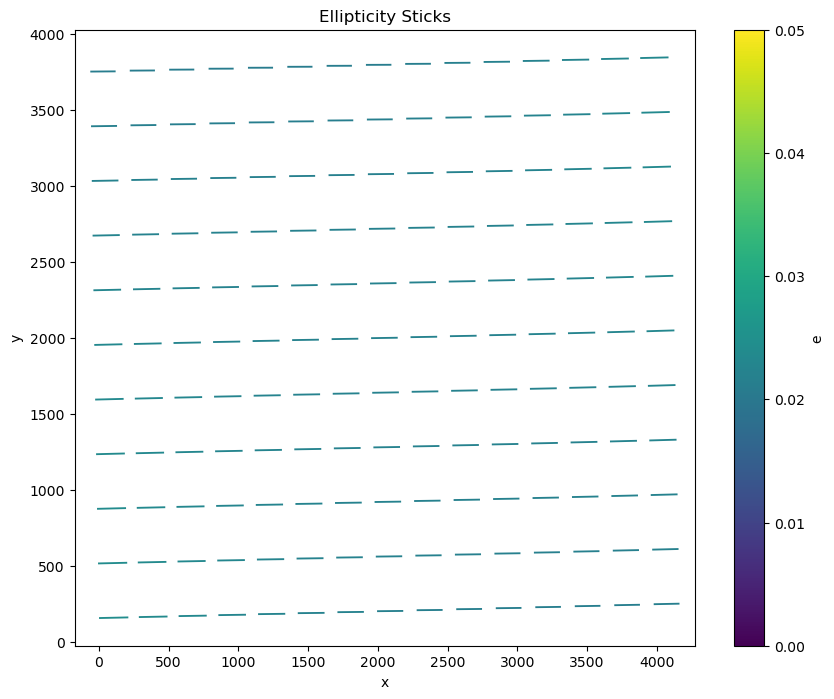

In [11]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.003)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')